Here we import the needed libraries

In [1]:
import numpy as np
import time
import os

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
dataset_train = "dataset/Train"
dataset_test = "dataset/Test"

We set the subfolders where we will store the downloaded ressources

In [3]:
keras_cache_dir = os.path.join(os.getcwd(),'keras_cache')
os.makedirs(keras_cache_dir, exist_ok = True)

tfhub_cache_dir = os.path.join(os.getcwd(),'tfhub_cache')
os.makedirs(tfhub_cache_dir, exist_ok = True)
os.environ['TFHUB_CACHE_DIR'] = tfhub_cache_dir

We load the train, validation and test dataset

In [4]:
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  dataset_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_test,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 8070 files belonging to 5 classes.
Using 6456 files for training.
Found 8070 files belonging to 5 classes.
Using 1614 files for validation.
Found 145 files belonging to 5 classes.


We set an array that contain the class names

In [5]:
class_names = np.array(train_ds.class_names)
print(class_names)

['0' '1' '2' '3' '4']


We rescale the image models from the training dataset

In [6]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

We pre-fetch the model with the tf.data.AUTOTUNE to increase the learning performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [9]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4" #@param {type:"string"}

We freeze the weight in the feature extractor

In [10]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

We set the feature extractor in the model

In [11]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


We configure the new model process with compile

In [12]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

We train the model

In [13]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

    self.val_losses = []
    self.val_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

  def on_epoch_end(self, epoch, logs=None):
    self.val_losses.append(logs['val_loss'])
    self.val_acc.append(logs['val_acc'])
    self.model.reset_metrics()

batch_stats_callback = CollectBatchStats()

history = model.fit(train_ds, epochs=10, callbacks=[batch_stats_callback], validation_data=val_ds)

Epoch 1/10
202/202 [==============================] - 220s 1s/step - loss: 0.3892 - acc: 0.8750 - val_loss: 0.5967 - val_acc: 0.7862
Epoch 2/10
202/202 [==============================] - 205s 1s/step - loss: 0.2709 - acc: 0.9583 - val_loss: 0.4397 - val_acc: 0.8581
Epoch 3/10
202/202 [==============================] - 205s 1s/step - loss: 0.2245 - acc: 0.9583 - val_loss: 0.3734 - val_acc: 0.8792
Epoch 4/10
202/202 [==============================] - 208s 1s/step - loss: 0.1958 - acc: 0.9583 - val_loss: 0.3350 - val_acc: 0.8885
Epoch 5/10
202/202 [==============================] - 205s 1s/step - loss: 0.1747 - acc: 0.9583 - val_loss: 0.3087 - val_acc: 0.8959
Epoch 6/10
202/202 [==============================] - 205s 1s/step - loss: 0.1586 - acc: 1.0000 - val_loss: 0.2891 - val_acc: 0.9033
Epoch 7/10
202/202 [==============================] - 206s 1s/step - loss: 0.1459 - acc: 1.0000 - val_loss: 0.2737 - val_acc: 0.9095
Epoch 8/10
202/202 [==============================] - 204s 1s/step - 

We print 2 graphs of the evolution the model during the training for the train dataset and validation dataset

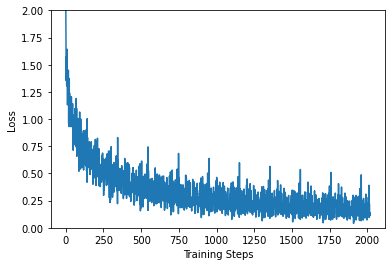

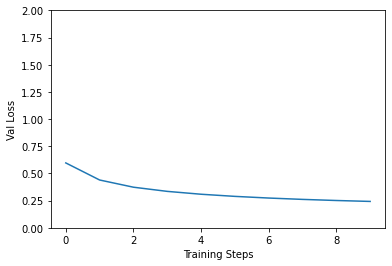

In [15]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses);

plt.figure()
plt.ylabel("Val Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.val_losses);

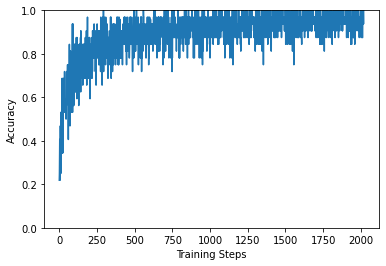

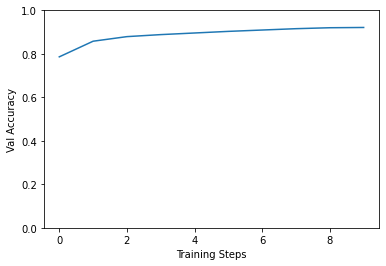

In [16]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc);

plt.figure()
plt.ylabel("Val Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.val_acc);

We evaluate our model without fine tuning and we save it

In [17]:
for image_batch_test, labels_batch_test in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [18]:
predicted_batch = model.predict(image_batch_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

evalutation_result = model.evaluate(image_batch_test, labels_batch_test, batch_size=batch_size)

1/1 [==============================] - 2s 2s/step - loss: 1.3427 - acc: 0.7188


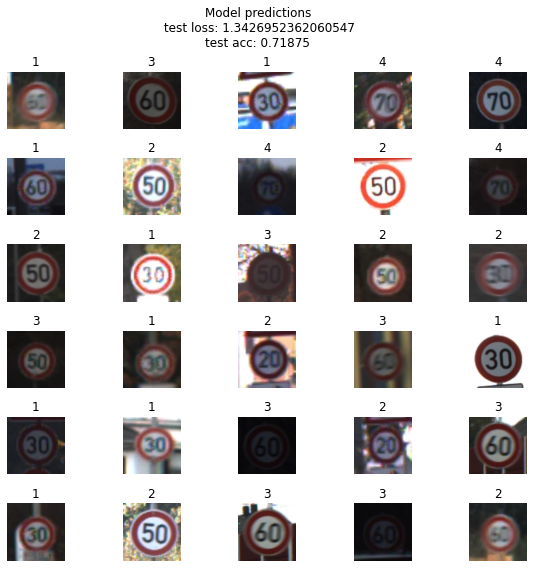

In [19]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions\n test loss: " + str(evalutation_result[0]) + "\ntest acc: " + str(evalutation_result[1]))

In [20]:
t = time.time()

export_path = f"saved_models/model_1"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/model_1/assets
INFO:tensorflow:Assets written to: saved_models/model_1/assets


'saved_models/model_1'

We now unfreeze our feature extractor and we set a very low learning rate to do fine tuning 

In [21]:
feature_extractor_layer.trainable = True

model.compile(
  optimizer=tf.keras.optimizers.Adam(1e-5),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [22]:
history = model.fit(train_ds, epochs=10, callbacks=[batch_stats_callback], validation_data=val_ds)

Epoch 1/10
202/202 [==============================] - 1348s 7s/step - loss: 0.4762 - acc: 0.8333 - val_loss: 1.4556 - val_acc: 0.5973
Epoch 2/10
202/202 [==============================] - 1317s 7s/step - loss: 0.2143 - acc: 0.9583 - val_loss: 0.4541 - val_acc: 0.8705
Epoch 3/10
202/202 [==============================] - 1192s 6s/step - loss: 0.1346 - acc: 1.0000 - val_loss: 0.3236 - val_acc: 0.9133
Epoch 4/10
202/202 [==============================] - 1109s 5s/step - loss: 0.1072 - acc: 1.0000 - val_loss: 0.2828 - val_acc: 0.9281
Epoch 5/10
202/202 [==============================] - 1110s 5s/step - loss: 0.0977 - acc: 1.0000 - val_loss: 0.2580 - val_acc: 0.9399
Epoch 6/10
202/202 [==============================] - 1108s 5s/step - loss: 0.0927 - acc: 1.0000 - val_loss: 0.2417 - val_acc: 0.9467
Epoch 7/10
202/202 [==============================] - 1108s 5s/step - loss: 0.0898 - acc: 1.0000 - val_loss: 0.2300 - val_acc: 0.9492
Epoch 8/10
202/202 [==============================] - 1215s 6s

We display the sale 2 graphs with the fine tuned part

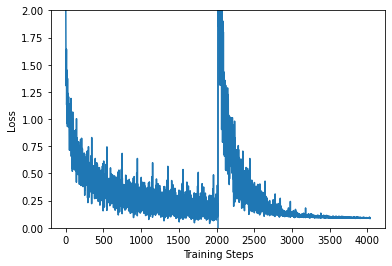

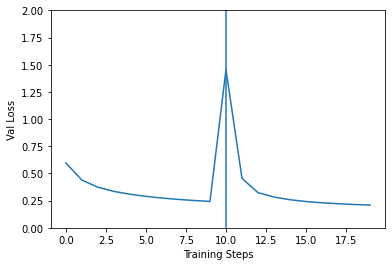

In [23]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.axvline(x=2020)
plt.plot(batch_stats_callback.batch_losses);

plt.figure()
plt.ylabel("Val Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.axvline(x=10)
plt.plot(batch_stats_callback.val_losses);

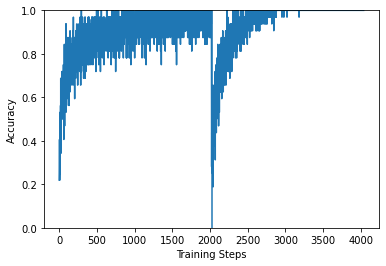

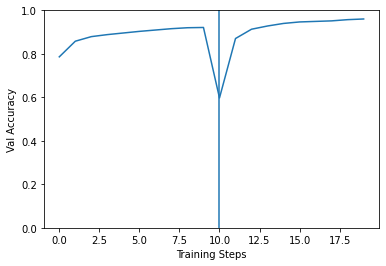

In [24]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.axvline(x=2020)
plt.plot(batch_stats_callback.batch_acc);

plt.figure()
plt.ylabel("Val Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.axvline(x=10)
plt.plot(batch_stats_callback.val_acc);

and evaluate it

In [25]:
predicted_batch = model.predict(image_batch_test)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

evalutation_result = model.evaluate(image_batch_test, labels_batch_test, batch_size=batch_size)

1/1 [==============================] - 1s 1s/step - loss: 1.5868 - acc: 0.6562


We display the 30 first result of this prectition

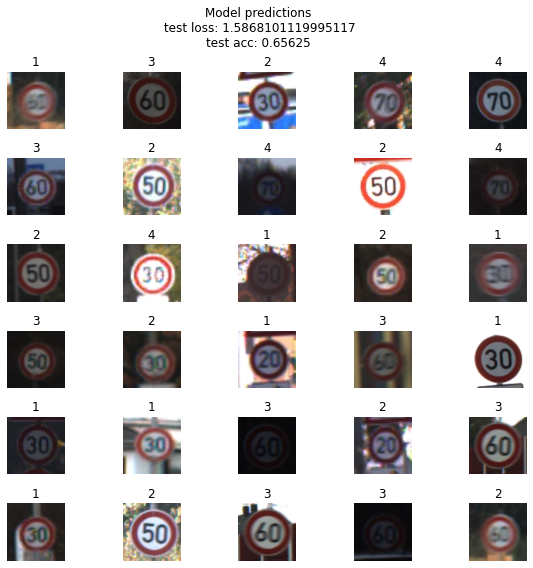

In [26]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch_test[n])
  plt.title(predicted_label_batch[n].title())
  plt.axis('off')
_ = plt.suptitle("Model predictions\n test loss: " + str(evalutation_result[0]) + "\ntest acc: " + str(evalutation_result[1]))

We save the model

In [14]:
t = time.time()

export_path = f"saved_models/model_1_fine"
model.save(export_path)

export_path

INFO:tensorflow:Assets written to: saved_models/model_1_fine/assets
INFO:tensorflow:Assets written to: saved_models/model_1_fine/assets


'saved_models/model_1_fine'

We see that the fine tuned model have a lower accuracy than before, we will therefor continue the assignment with the non fine-tuned model

The accuracy on the test set is 0.7